In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import sklearn as sk
import sklearn.model_selection
import albumentations as A #put off until later, after training the data. After the pretrained network is done

In [244]:
df_train_original = pd.read_csv('/content/drive/MyDrive/training.csv')
df_test = pd.read_csv('/content/drive/MyDrive/test.csv')
#use 20% of the data from the train csv file for the validation data
#used the median values to fill the nas
df_train, df_val = sk.model_selection.train_test_split(df_train_original, train_size = .8)
df_train.fillna(df_train.median(), inplace = True) 
df_val.fillna(df_val.median(), inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [245]:
#The class that configures the data into useable data frames
class FaceRecog(torch.utils.data.Dataset):
    def __init__(self, df, augment_data = False):
      self.df = df

      #augment data
      if augment_data:
        self.transform = A.Compose([
          A.Normalize()
        ])

      else:
        self.transform = A.Compose([
          A.Normalize(),
        ]) #only normalizing the data if not using training data
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,indx):
        row = self.df.iloc[indx]
        #print(row)
        bright_vals = row['Image']
        bright_vals = bright_vals.split()
        brightness = np.float32(bright_vals)
        brightness = np.reshape(brightness, (96,96)) #change to (1,96,96) when not using a pretrained network
        x = brightness #no need to divide by 255 because transform.normalize does that for me
        x = np.stack((x,x,x), axis = 2) #comment out depending on pretrained neural network, add axis 2 for data augmentation
        #starting data augmentation
        x = self.transform(image = x)['image']
        x = np.transpose(x, (2,0,1)) #shape pytorch wants
        #print(x.shape)
        
        y = np.array(row[0:30]) #should be used to read in the first 30 rows of the dataframe. Should be a numpy array that contains the data for the images
        y = np.reshape(y,30)
        y = np.float32(y)
        
        return x, y

In [246]:
#configuring the batch size and shuffling of the dataloader
batchsize = 16
shuffle = True
#Initializing the datasets
dataset_train = FaceRecog(df_train, augment_data = True) #we only augment the training data
dataset_test = FaceRecog(df_val, augment_data = False) #change to df_test when working on final product 
#creating the dataloaders
loader_train = torch.utils.data.DataLoader(dataset_train, batchsize, shuffle)
loader_test = torch.utils.data.DataLoader(dataset_test, batchsize, shuffle)

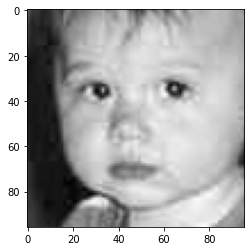

In [247]:
x_batch, y_batch = next(iter(loader_train))
plt.imshow(x_batch[0][0], cmap = 'gray') #for pretrained network
#plt.imshow(np.reshape(x_batch[0], (96,96)), cmap = 'gray')

In [248]:
#pretrained worked better
class MyNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1,64,3) 
        self.ReLU = torch.nn.ReLU() #64 arrays with 94x94
        self.pool = torch.nn.MaxPool2d(2) #64 arrays with47x47
        self.flatten = torch.nn.Flatten() #64*47*47
        #will be 30 because we are predicting 30 values for y (regression problem)
        self.dense1 = torch.nn.Linear(64*47*47,30) 
        
    def forward(self, x): #1, 94, 94
        x = self.conv1(x) #32, 92, 92
        x = self.ReLU(x) #32, 92, 92
        x = self.pool(x) #32, 46, 46
        x = self.flatten(x) #32*22*22
        x = self.dense1(x) #1, 30
        
        return x

In [249]:
#model = MyNetwork()
model = torchvision.models.resnet18(pretrained = True) #comment out when trying my own network
model.fc = torch.nn.Linear(512, 30) #for pretrained network
device = torch.device('cuda')
model = model.to(device)
MSE_loss = torch.nn.MSELoss() #something is wrong with the MSE values
optimizer = torch.optim.Adam(model.parameters(), lr = .001) #Adam, SGD

In [250]:
n_epochs = 15
n_train = len(dataset_train)
n_test = len(dataset_test)
train_losses = []
test_losses = []

In [251]:
x_batch = x_batch.to(device)
y_pred = model(x_batch)
#x_batch.shape 
y_pred[0].shape

torch.Size([30])

In [252]:
#looking for the lowest mean squared error value
for ep in range(n_epochs):
    model.train()
    train_loss = 0.0
    test_loss = 0.0
    batch_index = 0
    
    for x_batch, y_batch in loader_train:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        N_batch = x_batch.shape[0]
        outputs = model(x_batch)
        mse = MSE_loss(outputs, y_batch)
        
        model.zero_grad()
        mse.backward()
        optimizer.step()
        
        train_loss += mse*N_batch
        
    model.eval()
    val_loss = 0.0
    
    for x_batch, y_batch in loader_test:

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        with torch.no_grad(): #no need to keep track of gradient information

            N_batch = x_batch.shape[0]
            outputs = model(x_batch)
            mse = MSE_loss(outputs, y_batch)
            test_loss += mse*N_batch

    train_losses.append(train_loss/n_train)
    test_losses.append(test_loss/n_test)

    print('epoch: ', ep, ' train loss: ',train_loss/n_train, ' test_loss: ',test_loss/n_test)

epoch:  0  train loss:  tensor(237.9113, device='cuda:0', grad_fn=<DivBackward0>)  test_loss:  tensor(10.5171, device='cuda:0')
epoch:  1  train loss:  tensor(6.9016, device='cuda:0', grad_fn=<DivBackward0>)  test_loss:  tensor(10.0145, device='cuda:0')
epoch:  2  train loss:  tensor(6.5286, device='cuda:0', grad_fn=<DivBackward0>)  test_loss:  tensor(11.3803, device='cuda:0')
epoch:  3  train loss:  tensor(5.1622, device='cuda:0', grad_fn=<DivBackward0>)  test_loss:  tensor(4.7651, device='cuda:0')
epoch:  4  train loss:  tensor(4.7660, device='cuda:0', grad_fn=<DivBackward0>)  test_loss:  tensor(4.3931, device='cuda:0')
epoch:  5  train loss:  tensor(4.1243, device='cuda:0', grad_fn=<DivBackward0>)  test_loss:  tensor(4.2846, device='cuda:0')
epoch:  6  train loss:  tensor(3.8387, device='cuda:0', grad_fn=<DivBackward0>)  test_loss:  tensor(3.8321, device='cuda:0')
epoch:  7  train loss:  tensor(3.5435, device='cuda:0', grad_fn=<DivBackward0>)  test_loss:  tensor(3.7136, device='cuda

Text(0, 0.5, 'Objective Value')

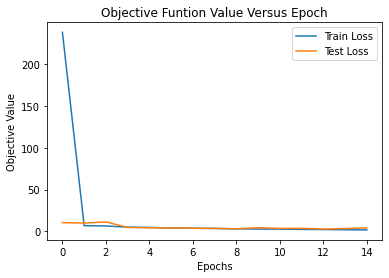

In [253]:
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.legend(loc = 'upper right')
plt.title('Objective Funtion Value Versus Epoch')
plt.xlabel('Epochs')
plt.ylabel('Objective Value')

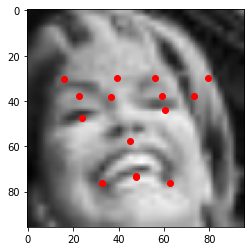

In [297]:
x_batch, y_batch = next(iter(loader_test))
x_int = []
y_int = []

for i in range(y_batch.shape[1]):
  if (i % 2 == 0):
    x_int.append(y_batch[0][i])
  else:
    y_int.append(y_batch[0][i])

plt.imshow(x_batch[0][0], cmap = 'gray') #for pretrained network
#plt.imshow(np.reshape(x_batch[0], (96,96)), cmap = 'gray')
plt.scatter(x_int, y_int, color = 'red')

In [298]:
# df_test = pd.read_csv('/content/drive/MyDrive/IdLookupTable.csv')

# load_tester = torch.utils.data.DataLoader(dataset_test, df_val.shape[0], shuffle = False)
# x_batch, y_batch = next(iter(load_tester))
# x_batch = x_batch.to(device)
# y_pred = model(x_batch)